In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import csv
import math
import sklearn
import os
from scipy.optimize import minimize
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import json
import seaborn as sns
from scipy import stats

# Part 1- Summary statistics and plots

***Initial Setup:*** First pull in the data set and explore the variables.

In [2]:
print(os.getcwd())
print(os.listdir())

C:\Users\blaiz\OneDrive\Documents\My Projects\Retail Profit Margin Project
['.ipynb_checkpoints', 'Before.png', 'fin.png', 'pmp_takehome_2019.csv', 'ratio.png', 'Retail gross profit margin.ipynb', 'RetailSlides.pptx', 'Take Home Assessment.pdf']


In [3]:
df = pd.read_csv('pmp_takehome_2019.csv')
dx = pd.read_csv('pmp_takehome_2019.csv')

In [4]:
df.head(5)

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False


In [5]:
df.columns

Index(['Location number', 'Month', 'State', 'Gross revenue', 'Fixed cost',
       'Variable cost', 'Rental cost', 'Number of products', 'Owned'],
      dtype='object')

Now take a look at the data set itself.

1) Look at the size

2) Check for Null values

3) Check for duplicates

In [6]:
df.shape

(3996, 9)

In [7]:
df.isnull().sum()

Location number       0
Month                 0
State                 0
Gross revenue         0
Fixed cost            0
Variable cost         0
Rental cost           0
Number of products    0
Owned                 0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe()

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products
count,3996.000000,3996.000000,3.996000e+03,3.996000e+03,3.996000e+03,3996.000000,3996.000000
mean,167.000000,6.500000,3.009181e+07,6.248363e+06,1.574127e+07,147721.231231,4510.978979
std,96.140417,3.452485,1.656374e+07,2.745097e+06,8.587854e+06,112552.592675,135.178179
min,1.000000,1.000000,3.307785e+06,5.743318e+05,1.644294e+06,0.000000,3810.000000
25%,84.000000,3.750000,1.882810e+07,4.471979e+06,9.915177e+06,73940.000000,4431.000000
50%,167.000000,6.500000,2.631416e+07,5.618382e+06,1.370027e+07,130970.000000,4527.000000
75%,250.000000,9.250000,3.727173e+07,7.246046e+06,1.920627e+07,195840.000000,4594.000000
max,333.000000,12.000000,1.184582e+08,2.306052e+07,5.931488e+07,689750.000000,4789.000000


Initial exploration shows that there are 9 variables, 3996 observations, no null values and no duplicates. This simplifies the wrangling and cleaning process.

Next, notice the month numbers, this illustrates that this is a timeseries dataset. This needs to be considered while working with the data. The location number illustrates which store it is.

### 1) Looking across all locations, calculate the mean and median annual profit margin of a typical store. Does the profit margin across locations appear normally distributed? Please visualize.  
Profit Margin, more commonly known as Net Profit Margin, measures the profitability of a company as compared to the revenue generated for a period. However, Profit Margin could also mean 'Gross Profit Margin', which is Revenue - COGS. The data set allows me to calculate both, therefore I will calculate both Net Profit Margin and Gross Profit Margin as both are useful measures. In fact, in this situation 'Gross Profit Margin' could be a better measure as some properties are owned and therefore do not have rent cost.

Net profit margin includes all costs. Gross profit margin only includes cost of goods sold. 

$$Net Profit Margin = Gross Revenue - Fixed Cost - Variable Cost - Rent Cost$$

$$Net Profit Margin Ratio= \frac{Gross Revenue - Fixed Cost - Variable Cost - Rent Cost}{Gross Revenue}$$

$$Gross Profit Margin = Gross Revenue-Variable Cost$$

$$Gross Profit Margin Ratio = \frac{Gross Revenue-Variable Cost}{Gross Revenue}$$

***Analysis***
First, we must confirm that each location has 12 months of data. The statement below confirms that there is no locaton with less or more than 12 months.

In [10]:
ttt=df.groupby('Location number').count().sort_values('Month')
(ttt.Month!=12).sum()

0

In [11]:
df.groupby('Location number').count().sort_values('Month').head(1)

,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
Location number,,,,,,,,
1,12,12,12,12,12,12,12,12


In [12]:
df.groupby('Location number').count().sort_values('Month').tail(1)

,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
Location number,,,,,,,,
333,12,12,12,12,12,12,12,12


We can group our data by their 'Location number' to annualize our data and find our means and medians of our profit margin calculations.

In [13]:
#Profit margin calculations for each observation
df['GrossProfitMargin']=(df['Gross revenue']-df['Variable cost'])
df['NetProfitMargin']=(df['Gross revenue']-df['Variable cost']-df['Fixed cost']-df['Rental cost'])
df['GrossProfitMarginRatio']=(df['Gross revenue']-df['Variable cost'])/df['Gross revenue']
df['NetProfitMarginRatio']=(df['Gross revenue']-df['Variable cost']-df['Fixed cost']-df['Rental cost'])/df['Gross revenue']

###### Answer to Question 1.1 - Median and Mean Profit Margin

In [14]:
#Mean annual profit margin across all locations [and other measures]
pd.options.display.float_format = '{:,.2f}'.format
df_loc=df.groupby('Location number').sum()
df_loc[['NetProfitMargin', 'GrossProfitMargin', 'Gross revenue', 'Fixed cost', 'Variable cost', 
               'Rental cost']].mean()

NetProfitMargin      95,453,449.83
GrossProfitMargin   172,206,464.78
Gross revenue       361,101,760.79
Fixed cost           74,980,360.18
Variable cost       188,895,296.01
Rental cost           1,772,654.77
dtype: float64

In [15]:
#Median annual profit margin across locations [and other measures]
df_loc[['NetProfitMargin', 'GrossProfitMargin', 'Gross revenue', 'Fixed cost', 'Variable cost', 
               'Rental cost']].median()

NetProfitMargin      81,611,260.13
GrossProfitMargin   149,053,377.93
Gross revenue       319,380,364.45
Fixed cost           67,571,048.86
Variable cost       165,665,299.51
Rental cost           1,571,640.00
dtype: float64

***Answer Question 1.1 - Distribution of median and mean profit margins accross locations***
Check the distributions of the mean and median profit margins across locations.

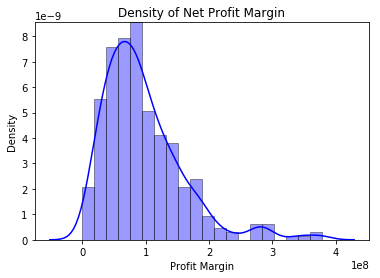

In [18]:
sns.distplot(df_loc.NetProfitMargin, hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})
plt.title('Density of Net Profit Margin')
plt.xlabel('Profit Margin')
plt.ylabel('Density')
plt.show()

Create QQ-Plot to check for normal distribution

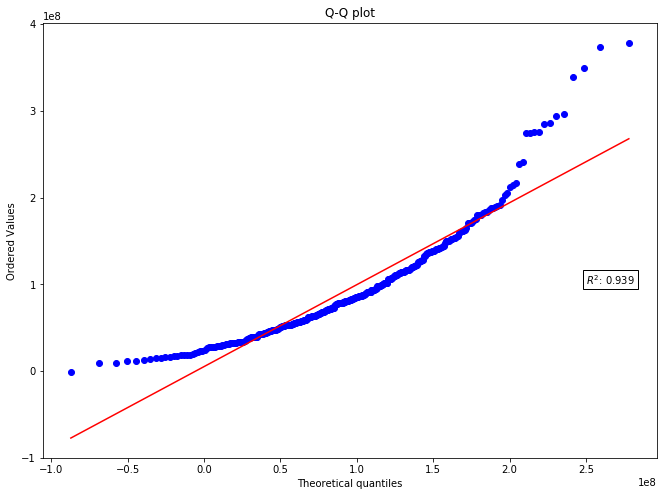

In [19]:
#QQ plot function to test for normality
import matplotlib.pyplot as plt
import scipy.stats as sp


def qq_plot(series, figsize=(11, 8)):
    """compare given series to Normal distirbution
    with matching location & scale"""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    arrs, res = sp.probplot(series, 
                            dist=sp.norm, 
                            sparams=(series.mean(), series.std()), 
                            plot=ax)
    bbox = {'fc': '1', 'pad': 3}
    xy = (ax.get_xticks()[-2], ax.get_yticks()[2])
    text = ax.annotate(r'$R^2$: {}'.format(round(res[2], 3)),
                     xy=xy,
                     bbox=bbox)
    title = ax.set_title('Q-Q plot')
qq_plot(df_loc['NetProfitMargin'], figsize=(11,8))
plt.show()

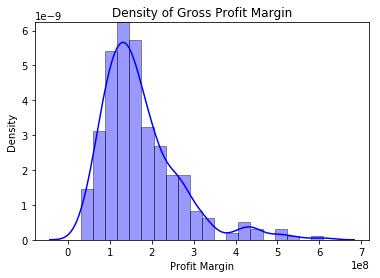

In [20]:
sns.distplot(df_loc.GrossProfitMargin, hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})
plt.title('Density of Gross Profit Margin')
plt.xlabel('Profit Margin')
plt.ylabel('Density')
plt.show()

Create QQ-Plot to check for normal distribution

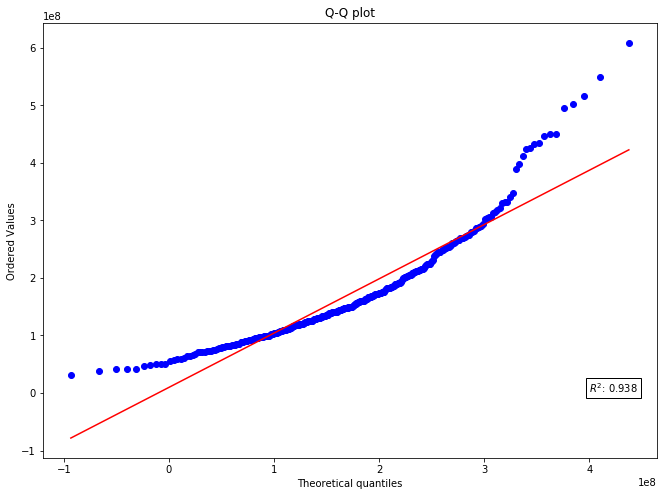

In [21]:
qq_plot(df_loc['GrossProfitMargin'], figsize=(11,8))
plt.show()

***Explanation*** Profit Margin is not normally distributed across all locations. While there is a strong central tendency, the right tail is much longer than the left.

### 2) Please plot the monthly and quarterly aggregate revenue across all stores. 

In [22]:
df.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
0,1,1,TX,"48,628,171.02","9,218,156.69","24,278,189.23",365880,4452,False,"24,349,981.79","14,765,945.10",0.50,0.30
1,1,2,TX,"48,107,179.24","10,587,747.35","25,116,844.41",365880,4452,False,"22,990,334.83","12,036,707.48",0.48,0.25
2,1,3,TX,"64,352,278.29","10,193,873.77","33,703,499.83",365880,4452,False,"30,648,778.46","20,089,024.69",0.48,0.31
3,1,4,TX,"45,943,677.96","8,764,165.00","24,037,719.47",365880,4452,False,"21,905,958.49","12,775,913.49",0.48,0.28
4,1,5,TX,"32,761,434.98","8,022,116.43","16,432,119.18",365880,4452,False,"16,329,315.80","7,941,319.37",0.50,0.24


In [24]:
#Group by month, print aggregate monthly revenue
df_month_totals=df.groupby('Month').sum()
df_month_totals['Gross revenue']

Month
1     9,304,129,223.88
2     9,786,842,932.48
3    11,587,361,200.94
4     9,105,208,425.57
5     9,347,461,485.05
6    11,297,643,513.47
7     9,005,478,090.08
8     9,625,942,280.00
9    11,249,652,068.21
10    9,413,548,683.99
11    8,983,799,310.00
12   11,539,819,130.65
Name: Gross revenue, dtype: float64

Text(0, 0.5, 'Revenue in Tens of Billions')

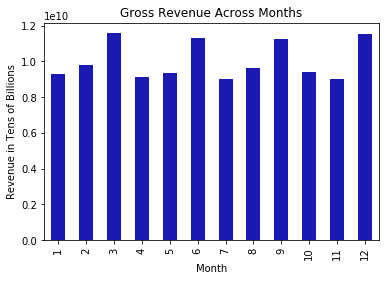

In [26]:
#Bar graph
df_month_totals['Gross revenue'].plot(kind='bar', color=(.1, .1, .7))
plt.title('Gross Revenue Across Months')
plt.ylabel('Revenue in Tens of Billions')
#There is a notable increase in revenue at the final month of each quarter

In [27]:
#First, I create a new variable called Qtr and assign each observation a value depending on the month.
#Jan - Mar: Qtr1, Apr-June: Qtr2, July-Sep: Qtr3 and Oct-Dec: Qtr4

df['Qtr']=np.where(df.Month <= 3, "Qtr1",
                  np.where((df.Month > 3) & (df.Month <=6), "Qtr2",
                          np.where((df.Month > 6) & (df.Month <=9), "Qtr3", "Qtr4")))

#Aggregate gross revenue for each quarter
df_Qtr_totals=df.groupby('Qtr').sum()
df_Qtr_totals['Gross revenue']

Qtr
Qtr1   30,678,333,357.29
Qtr2   29,750,313,424.08
Qtr3   29,881,072,438.29
Qtr4   29,937,167,124.63
Name: Gross revenue, dtype: float64

Text(0, 0.5, 'Revenue in Tens of Billions')

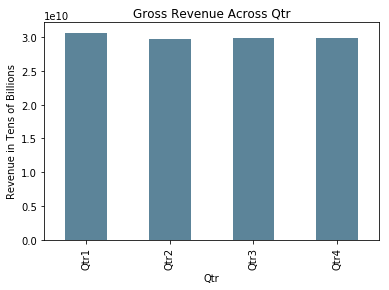

In [28]:
#Bar graph for quarters
df_Qtr_totals['Gross revenue'].plot(kind='bar', color=(0.2, 0.4, 0.5, 0.8))
plt.title('Gross Revenue Across Qtr')
plt.ylabel('Revenue in Tens of Billions')

# Part 2 – Cleaning the data:  
### You will have noticed that the company operates both owned and leased locations. This creates an apples-to-oranges comparison, as only the leased locations are burdened with rental cost. To prep your data for analysis, please impute an appropriate rental cost for each owned location and recalculate the rent-adjusted annual profit margin.

There are a couple different ways to impute an appropriate rental cost for owned locations. The easiest would be to find the mean or median rental cost of rented locations and then apply it to the owned locations. However, this is a relatively simplified approach and does not account for revenue size, location and product counts. 

The most appropriate measure is typically square footage, which is likely the largest determinate of rental cost. However, this is not available. Instead, there are two available proxies to size ('Number of products' and 'Gross revenue'). These are both appropriate methods given the constraints on the available data.

***Problem***
There is no square foot variable within the data, however, the data does contain the 'Number of products' which will act as a proxy to physical size. 

1) First, exclude the owned locations from our initial calculation as we do not want to bias our rental costs. Accomplish this by pulling only the data with a False value in the owned column. 

2) Next, divide the rental cost of each location by the number of products that location carries. With an inital eye test it appears that the rental cost and number of products does not change throughout the year, however, to be sure group the data by location number and then conduct the calculation.


In [31]:
#Checking ratio of owned to rented locations
df.Owned.value_counts(normalize=True)
#Only 11% of locations are owned the rest are rented

False   0.89
True    0.11
Name: Owned, dtype: float64

In [33]:
print(df.State.unique())
print(df[df.Owned ==False].State.unique())
#Each state has both rented and owned locations

['TX' 'IL' 'GA' 'NJ' 'CA' 'CO' 'WA']
['TX' 'GA' 'NJ' 'IL' 'CA' 'CO' 'WA']


In [34]:
#Creating ratio
df_ratio=df[df.Owned ==False].groupby('Location number').mean()
df_ratio['ratProd']=df_ratio['Rental cost']/df_ratio['Number of products']
df_ratio['ratRev']=df_ratio['Rental cost']/df_ratio['Gross revenue']
ratioRatProd=df_ratio.ratProd.mean()
ratioRatRev=df_ratio.ratRev.mean()
print(df_ratio.ratProd.mean())
print(df_ratio.ratRev.mean())

36.92467193637334
0.006031603905362026


In [35]:
#Apply the ratio to calculate rental cost for owned properties
dffProd=df.copy()
dffRev=df.copy()
dffProd['Rental cost'].replace(0, dffProd['Number of products']*ratioRatProd, inplace=True)
dffProd[dffProd.Owned==True].head(10)

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio,Qtr
24,3,1,IL,"30,791,018.69","6,123,108.00","17,948,338.14","170,591.98",4620,True,"12,842,680.55","6,719,572.55",0.42,0.22,Qtr1
25,3,2,IL,"23,805,331.16","5,014,361.53","13,051,817.38","170,591.98",4620,True,"10,753,513.78","5,739,152.25",0.45,0.24,Qtr1
26,3,3,IL,"33,916,624.99","6,043,273.71","19,190,769.99","170,591.98",4620,True,"14,725,855.00","8,682,581.29",0.43,0.26,Qtr1
27,3,4,IL,"24,170,582.83","5,196,755.17","13,505,396.58","170,591.98",4620,True,"10,665,186.25","5,468,431.08",0.44,0.23,Qtr2
28,3,5,IL,"24,925,332.00","4,688,566.82","14,531,349.44","170,591.98",4620,True,"10,393,982.56","5,705,415.74",0.42,0.23,Qtr2
29,3,6,IL,"36,980,121.91","6,078,797.20","20,381,261.95","170,591.98",4620,True,"16,598,859.96","10,520,062.76",0.45,0.28,Qtr2
30,3,7,IL,"21,011,894.45","5,069,282.69","11,654,140.58","170,591.98",4620,True,"9,357,753.87","4,288,471.18",0.45,0.20,Qtr3
31,3,8,IL,"27,514,438.90","5,013,502.99","14,802,054.99","170,591.98",4620,True,"12,712,383.91","7,698,880.92",0.46,0.28,Qtr3
32,3,9,IL,"32,256,311.50","6,207,097.39","17,951,211.29","170,591.98",4620,True,"14,305,100.21","8,098,002.82",0.44,0.25,Qtr3
33,3,10,IL,"27,700,978.92","4,466,050.60","15,082,147.54","170,591.98",4620,True,"12,618,831.38","8,152,780.78",0.46,0.29,Qtr4


Check to see the influence on the distribution of rental cost now that the 0 values have been replaced

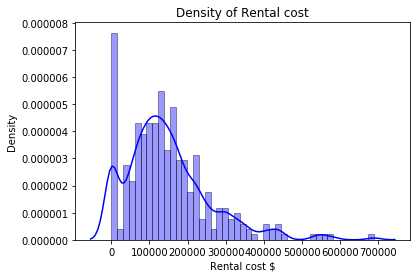

In [37]:
#Distribution of original rental costs. We see a large density at zero which are the owned properties that do not yet have rental cost.
sns.distplot(df['Rental cost'], hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})
plt.title('Density of Rental cost')
plt.xlabel('Rental cost $')
plt.ylabel('Density')
plt.show()

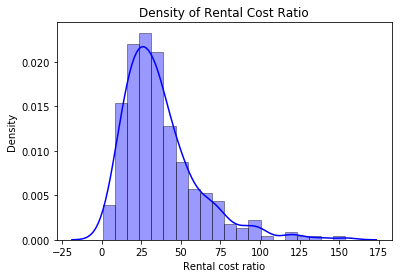

In [38]:
#This is the distribution of the calculated ratio. It follows a similar distribution to our rental cost excluding the owned properties.
sns.distplot(df_ratio['ratProd'], hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})
plt.title('Density of Rental Cost Ratio')
plt.xlabel('Rental cost ratio')
plt.ylabel('Density')
plt.show()

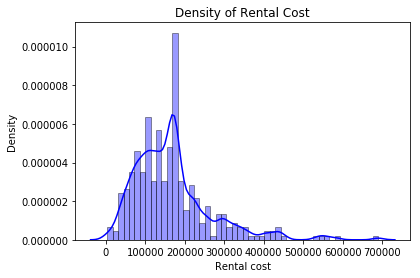

In [39]:
#This is our new rental cost distribution having replaced the $0 rental costs with appropriate rent. 
sns.distplot(dffProd['Rental cost'], hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})
plt.title('Density of Rental Cost')
plt.xlabel('Rental cost')
plt.ylabel('Density')
plt.show()

Because we used the mean of the properties to create our ratio, we expect there to be an increase in density around the mean. In the plot above we see that this increase at the mean did take place.

In [40]:
#Now we compare the mean of our rental cost excluding owned properties with our rental cost including both owned
#and rented properties.
#We see that regardless of the added rented costs the mean stays relatively the same.
#This process increases the central tendency of our rental cost.
print(df[df.Owned==False]['Rental cost'].mean())
print(dffProd['Rental cost'].mean())
print(dffProd[dffProd.Owned==True]['Rental cost'].mean())

165626.83501683502
166375.17630784458
172548.9919586729


***Answer Question 2 - Recalculate rent adjusted annual profit margin***

In [41]:
#Profit margin calculations for each observation
dffProd['GrossProfitMargin']=(dffProd['Gross revenue']-dffProd['Variable cost'])
dffProd['NetProfitMargin']=(dffProd['Gross revenue']-dffProd['Variable cost']-dffProd['Fixed cost']-dffProd['Rental cost'])
dffProd['GrossProfitMarginRatio']=(dffProd['Gross revenue']-dffProd['Variable cost'])/dffProd['Gross revenue']
dffProd['NetProfitMarginRatio']=(dffProd['Gross revenue']-dffProd['Variable cost']-dffProd['Fixed cost']-dffProd['Rental cost'])/dffProd['Gross revenue']

In [42]:
#Mean annual profit margin with rent adjustments
dff_loc=dffProd.groupby('Location number').sum()
dff_loc[['NetProfitMargin', 'GrossProfitMargin', 'Rental cost']].mean()

NetProfitMargin      95,229,602.49
GrossProfitMargin   172,206,464.78
Rental cost           1,996,502.12
dtype: float64

In [43]:
#Original mean profit margins
df_loc[['NetProfitMargin', 'GrossProfitMargin', 'Rental cost']].mean()

NetProfitMargin      95,453,449.83
GrossProfitMargin   172,206,464.78
Rental cost           1,772,654.77
dtype: float64

In [44]:
#Median annual profit margin with rent adjustments
dff_loc=dffProd.groupby('Location number').sum()
dff_loc[['NetProfitMargin', 'GrossProfitMargin', 'Rental cost']].median()

NetProfitMargin      80,817,944.89
GrossProfitMargin   149,053,377.93
Rental cost           1,873,800.00
dtype: float64

In [45]:
#Original median profit margin
df_loc[['NetProfitMargin', 'GrossProfitMargin', 'Rental cost']].median()

NetProfitMargin      81,611,260.13
GrossProfitMargin   149,053,377.93
Rental cost           1,571,640.00
dtype: float64

Net profit margin slightly decreased which is expected because as is shown above the owned properties now are including a rent cost in the net profit margin calculation. It is not however a drastic change. This is for two reasons. First, the number of rented properties far outweighs the number of owned properties. So, the effect will be less dramatic because most of the observations didn't have any change. The second reason is that in comparison to fixed cost and variable cost, rental cost is a smaller portion of total cost. 

# Part 3 – Quantify drivers of success:  
### With the data now cleaned, please identify factors that have led to historical outperformance across locations. The CEO is principally focused on maximizing profit margin at each location. There is no single correct answer for this section. We are more interested in your problem-solving process than any singular answer.  

### In response to the CEO’s question, please write a concise email describing your high level findings, and prepare a 2-3 slide powerpoint  

In [46]:
dff=dffProd.copy()
dff.columns

Index(['Location number', 'Month', 'State', 'Gross revenue', 'Fixed cost',
       'Variable cost', 'Rental cost', 'Number of products', 'Owned',
       'GrossProfitMargin', 'NetProfitMargin', 'GrossProfitMarginRatio',
       'NetProfitMarginRatio', 'Qtr'],
      dtype='object')

In [47]:
dff.shape

(3996, 14)

In [48]:
#No need to change the index at this time
dff.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio,Qtr
0,1,1,TX,"48,628,171.02","9,218,156.69","24,278,189.23","365,880.00",4452,False,"24,349,981.79","14,765,945.10",0.50,0.30,Qtr1
1,1,2,TX,"48,107,179.24","10,587,747.35","25,116,844.41","365,880.00",4452,False,"22,990,334.83","12,036,707.48",0.48,0.25,Qtr1
2,1,3,TX,"64,352,278.29","10,193,873.77","33,703,499.83","365,880.00",4452,False,"30,648,778.46","20,089,024.69",0.48,0.31,Qtr1
3,1,4,TX,"45,943,677.96","8,764,165.00","24,037,719.47","365,880.00",4452,False,"21,905,958.49","12,775,913.49",0.48,0.28,Qtr2
4,1,5,TX,"32,761,434.98","8,022,116.43","16,432,119.18","365,880.00",4452,False,"16,329,315.80","7,941,319.37",0.50,0.24,Qtr2


###### Exploration:
It is important to understand the data to the best of our abilities. Now that the data has been cleaned it is time to further explore the variables.

First, look at the categorical variable, 'State'. Look to see how many states are within the data and if some states are more heavily represented. 

In [49]:
dff.State.value_counts(normalize=True)

TX   0.30
CA   0.19
GA   0.16
IL   0.16
NJ   0.10
CO   0.05
WA   0.04
Name: State, dtype: float64

TX is the most represented state and WA is the least represented. Look at some of the differences between the states, however when checking for general statistics between states do not use sum. The states are not equally represented. This means median and mean are likely our best choices for aggregating our data. 

_Note:_ Continue to check distributions. As was shown earlier profit margin is not perfectly normal, however the tails and skew are not extreme. Mean would still be a reasonable calculation to perform.

In [50]:
dff.groupby('State').median()

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
State,,,,,,,,,,,,
CA,170.00,6.50,"26,569,206.86","5,598,703.25","13,795,629.07","147,860.00","4,496.00",False,"12,621,674.58","6,899,085.20",0.48,0.26
CO,186.00,6.50,"27,190,750.37","5,736,374.04","14,186,597.67","171,293.55","4,514.00",False,"12,801,856.14","6,809,159.79",0.49,0.26
GA,167.00,6.50,"22,982,363.59","5,404,196.85","12,715,326.77","140,410.00","4,522.50",False,"10,412,046.36","4,970,109.08",0.45,0.21
IL,148.50,6.50,"26,903,623.12","5,673,867.22","13,773,754.71","164,880.00","4,551.50",False,"12,866,011.87","6,919,765.58",0.48,0.26
NJ,138.00,6.50,"24,180,741.26","5,698,424.99","13,318,683.27","165,320.00","4,520.00",False,"10,575,942.59","5,050,855.23",0.44,0.20
TX,181.00,6.50,"28,284,802.19","5,693,584.02","14,322,834.24","156,150.00","4,531.00",False,"14,090,919.12","8,141,841.57",0.49,0.29
WA,148.00,6.50,"25,535,682.93","5,403,032.95","12,839,071.99","173,109.49","4,529.50",False,"12,453,039.62","6,579,978.20",0.49,0.25


In [51]:
dff.groupby('State').mean()

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
State,,,,,,,,,,,,
CA,168.44,6.50,"28,653,637.05","5,842,122.31","14,830,391.43","163,083.43","4,500.11",0.05,"13,823,245.61","7,818,039.87",0.48,0.25
CO,179.60,6.50,"32,535,583.08","6,864,148.42","16,912,661.24","161,276.84","4,526.27",0.13,"15,622,921.84","8,597,496.58",0.48,0.25
GA,161.91,6.50,"26,377,271.80","5,949,180.26","14,481,274.61","154,156.65","4,508.31",0.07,"11,895,997.19","5,792,660.29",0.45,0.20
IL,157.22,6.50,"29,107,092.01","6,033,666.55","15,220,073.16","162,086.70","4,534.09",0.22,"13,887,018.85","7,691,265.60",0.47,0.25
NJ,154.59,6.50,"29,657,333.76","6,619,245.64","16,529,461.55","166,488.32","4,499.97",0.09,"13,127,872.21","6,342,138.24",0.44,0.19
TX,178.43,6.50,"33,698,018.24","6,642,198.11","17,099,428.06","178,021.97","4,513.45",0.11,"16,598,590.18","9,778,370.10",0.49,0.27
WA,150.29,6.50,"27,047,915.23","5,709,819.00","13,855,864.42","166,038.50","4,472.00",0.07,"13,192,050.81","7,316,193.31",0.49,0.24


In [52]:
#Check and see which states have the highest and lowest rental costs
dff.groupby('State').median().sort_values('Rental cost')
#GA has the lowest rental cost
#WA has the highest rental cost

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
State,,,,,,,,,,,,
GA,167.00,6.50,"22,982,363.59","5,404,196.85","12,715,326.77","140,410.00","4,522.50",False,"10,412,046.36","4,970,109.08",0.45,0.21
CA,170.00,6.50,"26,569,206.86","5,598,703.25","13,795,629.07","147,860.00","4,496.00",False,"12,621,674.58","6,899,085.20",0.48,0.26
TX,181.00,6.50,"28,284,802.19","5,693,584.02","14,322,834.24","156,150.00","4,531.00",False,"14,090,919.12","8,141,841.57",0.49,0.29
IL,148.50,6.50,"26,903,623.12","5,673,867.22","13,773,754.71","164,880.00","4,551.50",False,"12,866,011.87","6,919,765.58",0.48,0.26
NJ,138.00,6.50,"24,180,741.26","5,698,424.99","13,318,683.27","165,320.00","4,520.00",False,"10,575,942.59","5,050,855.23",0.44,0.20
CO,186.00,6.50,"27,190,750.37","5,736,374.04","14,186,597.67","171,293.55","4,514.00",False,"12,801,856.14","6,809,159.79",0.49,0.26
WA,148.00,6.50,"25,535,682.93","5,403,032.95","12,839,071.99","173,109.49","4,529.50",False,"12,453,039.62","6,579,978.20",0.49,0.25


In [53]:
#Check and see which states have the highest and lowest gross revenue
dff.groupby('State').median().sort_values('Gross revenue')
#GA has the lowest Gross Revenue
#TX has the highest Gross Revenue

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
State,,,,,,,,,,,,
GA,167.00,6.50,"22,982,363.59","5,404,196.85","12,715,326.77","140,410.00","4,522.50",False,"10,412,046.36","4,970,109.08",0.45,0.21
NJ,138.00,6.50,"24,180,741.26","5,698,424.99","13,318,683.27","165,320.00","4,520.00",False,"10,575,942.59","5,050,855.23",0.44,0.20
WA,148.00,6.50,"25,535,682.93","5,403,032.95","12,839,071.99","173,109.49","4,529.50",False,"12,453,039.62","6,579,978.20",0.49,0.25
CA,170.00,6.50,"26,569,206.86","5,598,703.25","13,795,629.07","147,860.00","4,496.00",False,"12,621,674.58","6,899,085.20",0.48,0.26
IL,148.50,6.50,"26,903,623.12","5,673,867.22","13,773,754.71","164,880.00","4,551.50",False,"12,866,011.87","6,919,765.58",0.48,0.26
CO,186.00,6.50,"27,190,750.37","5,736,374.04","14,186,597.67","171,293.55","4,514.00",False,"12,801,856.14","6,809,159.79",0.49,0.26
TX,181.00,6.50,"28,284,802.19","5,693,584.02","14,322,834.24","156,150.00","4,531.00",False,"14,090,919.12","8,141,841.57",0.49,0.29


In [54]:
#Check and see which states have the highest and lowest variable cost
dff.groupby('State').median().sort_values('Variable cost')
#GA has lowest variable cost and TX has highest variable cost
#This makes sense as we see above that GA has lowest gross revenue meaning they sell the least, thus decreasing their variable cost
#TX works vice versa as they appear to sell the most thus have the highest variable cost

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
State,,,,,,,,,,,,
GA,167.00,6.50,"22,982,363.59","5,404,196.85","12,715,326.77","140,410.00","4,522.50",False,"10,412,046.36","4,970,109.08",0.45,0.21
WA,148.00,6.50,"25,535,682.93","5,403,032.95","12,839,071.99","173,109.49","4,529.50",False,"12,453,039.62","6,579,978.20",0.49,0.25
NJ,138.00,6.50,"24,180,741.26","5,698,424.99","13,318,683.27","165,320.00","4,520.00",False,"10,575,942.59","5,050,855.23",0.44,0.20
IL,148.50,6.50,"26,903,623.12","5,673,867.22","13,773,754.71","164,880.00","4,551.50",False,"12,866,011.87","6,919,765.58",0.48,0.26
CA,170.00,6.50,"26,569,206.86","5,598,703.25","13,795,629.07","147,860.00","4,496.00",False,"12,621,674.58","6,899,085.20",0.48,0.26
CO,186.00,6.50,"27,190,750.37","5,736,374.04","14,186,597.67","171,293.55","4,514.00",False,"12,801,856.14","6,809,159.79",0.49,0.26
TX,181.00,6.50,"28,284,802.19","5,693,584.02","14,322,834.24","156,150.00","4,531.00",False,"14,090,919.12","8,141,841.57",0.49,0.29


In [55]:
#Check and see which states have the highest and lowest fixed cost
dff.groupby('State').median().sort_values('Fixed cost')
#Fixed cost and rental cost differences are marginal in comparison to the gross revenue and variable cost

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
State,,,,,,,,,,,,
WA,148.00,6.50,"25,535,682.93","5,403,032.95","12,839,071.99","173,109.49","4,529.50",False,"12,453,039.62","6,579,978.20",0.49,0.25
GA,167.00,6.50,"22,982,363.59","5,404,196.85","12,715,326.77","140,410.00","4,522.50",False,"10,412,046.36","4,970,109.08",0.45,0.21
CA,170.00,6.50,"26,569,206.86","5,598,703.25","13,795,629.07","147,860.00","4,496.00",False,"12,621,674.58","6,899,085.20",0.48,0.26
IL,148.50,6.50,"26,903,623.12","5,673,867.22","13,773,754.71","164,880.00","4,551.50",False,"12,866,011.87","6,919,765.58",0.48,0.26
TX,181.00,6.50,"28,284,802.19","5,693,584.02","14,322,834.24","156,150.00","4,531.00",False,"14,090,919.12","8,141,841.57",0.49,0.29
NJ,138.00,6.50,"24,180,741.26","5,698,424.99","13,318,683.27","165,320.00","4,520.00",False,"10,575,942.59","5,050,855.23",0.44,0.20
CO,186.00,6.50,"27,190,750.37","5,736,374.04","14,186,597.67","171,293.55","4,514.00",False,"12,801,856.14","6,809,159.79",0.49,0.26


In [56]:
#Check and see which states have the highest and lowest net profit margin
dff.groupby('State').median().sort_values('NetProfitMargin')
#As we see fixed cost is relatively consistent throughout the states, 
#thus, if gross revenue increases then variable cost increases but net profit margin should be higher.
#In this data this assumption holds true, Texas has the highest gross revenue and net profit margin.

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
State,,,,,,,,,,,,
GA,167.00,6.50,"22,982,363.59","5,404,196.85","12,715,326.77","140,410.00","4,522.50",False,"10,412,046.36","4,970,109.08",0.45,0.21
NJ,138.00,6.50,"24,180,741.26","5,698,424.99","13,318,683.27","165,320.00","4,520.00",False,"10,575,942.59","5,050,855.23",0.44,0.20
WA,148.00,6.50,"25,535,682.93","5,403,032.95","12,839,071.99","173,109.49","4,529.50",False,"12,453,039.62","6,579,978.20",0.49,0.25
CO,186.00,6.50,"27,190,750.37","5,736,374.04","14,186,597.67","171,293.55","4,514.00",False,"12,801,856.14","6,809,159.79",0.49,0.26
CA,170.00,6.50,"26,569,206.86","5,598,703.25","13,795,629.07","147,860.00","4,496.00",False,"12,621,674.58","6,899,085.20",0.48,0.26
IL,148.50,6.50,"26,903,623.12","5,673,867.22","13,773,754.71","164,880.00","4,551.50",False,"12,866,011.87","6,919,765.58",0.48,0.26
TX,181.00,6.50,"28,284,802.19","5,693,584.02","14,322,834.24","156,150.00","4,531.00",False,"14,090,919.12","8,141,841.57",0.49,0.29


There are a couple of interesting discoveries. First, and most importantly median 'Profit Margin' is considerably different depending on the state in which the store is located (the difference is even larger when looking at the mean). What is causing this?


***Number of products*** I would like to see if the number of products effects net profit margin. First, bin the data. Below, I have created different quantiles that will act as my bin's ranges.

In [58]:
dff['Number of products'].quantile([0,.2, .4, .6,.8, 1])

0.00   3,810.00
0.20   4,411.00
0.40   4,494.00
0.60   4,553.00
0.80   4,623.00
1.00   4,789.00
Name: Number of products, dtype: float64

In [59]:
#Bin the observations by number of number of products carried
dff['Bin']=np.where(dff['Number of products']<= 4411, "Bin 4333",
                  np.where((dff['Number of products'] > 4411) & (dff['Number of products'] <=4494), "Bin 4431",
                          np.where((dff['Number of products'] > 4494) & (dff['Number of products'] <=4553), "Bin 4527",
                                  np.where((dff['Number of products'] > 4553) & (dff['Number of products'] <=4623), "Bin 4679", "Bin4789"))))
dff.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio,Qtr,Bin
0,1,1,TX,"48,628,171.02","9,218,156.69","24,278,189.23","365,880.00",4452,False,"24,349,981.79","14,765,945.10",0.50,0.30,Qtr1,Bin 4431
1,1,2,TX,"48,107,179.24","10,587,747.35","25,116,844.41","365,880.00",4452,False,"22,990,334.83","12,036,707.48",0.48,0.25,Qtr1,Bin 4431
2,1,3,TX,"64,352,278.29","10,193,873.77","33,703,499.83","365,880.00",4452,False,"30,648,778.46","20,089,024.69",0.48,0.31,Qtr1,Bin 4431
3,1,4,TX,"45,943,677.96","8,764,165.00","24,037,719.47","365,880.00",4452,False,"21,905,958.49","12,775,913.49",0.48,0.28,Qtr2,Bin 4431
4,1,5,TX,"32,761,434.98","8,022,116.43","16,432,119.18","365,880.00",4452,False,"16,329,315.80","7,941,319.37",0.50,0.24,Qtr2,Bin 4431


In [60]:
#Similar number of observations in each bin
dff.groupby('Bin').count().State

Bin
Bin 4333    804
Bin 4431    804
Bin 4527    792
Bin 4679    804
Bin4789     792
Name: State, dtype: int64

In [61]:
dff.groupby('Bin').mean().sort_values('NetProfitMargin')

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
Bin,,,,,,,,,,,,
Bin 4333,158.06,6.50,"18,948,364.41","4,933,734.62","10,440,146.26","157,985.67","4,311.97",0.00,"8,508,218.15","3,416,497.86",0.45,0.16
Bin 4431,178.27,6.50,"27,581,203.97","6,137,508.81","14,764,278.58","190,695.82","4,452.79",0.00,"12,816,925.39","6,488,720.76",0.46,0.22
Bin 4527,150.05,6.50,"30,256,186.79","6,160,417.91","15,897,488.33","172,027.73","4,525.20",0.00,"14,358,698.46","8,026,252.82",0.48,0.26
Bin 4679,163.93,6.50,"34,234,339.66","6,640,577.96","17,706,017.24","166,850.87","4,583.48",0.12,"16,528,322.41","9,720,893.58",0.48,0.28
Bin4789,184.71,6.50,"39,583,086.30","7,385,233.02","19,963,797.21","144,067.20","4,684.26",0.42,"19,619,289.09","12,089,988.87",0.50,0.30


In [62]:
dff.groupby('Bin').mean().sort_values('NetProfitMarginRatio')

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio
Bin,,,,,,,,,,,,
Bin 4333,158.06,6.50,"18,948,364.41","4,933,734.62","10,440,146.26","157,985.67","4,311.97",0.00,"8,508,218.15","3,416,497.86",0.45,0.16
Bin 4431,178.27,6.50,"27,581,203.97","6,137,508.81","14,764,278.58","190,695.82","4,452.79",0.00,"12,816,925.39","6,488,720.76",0.46,0.22
Bin 4527,150.05,6.50,"30,256,186.79","6,160,417.91","15,897,488.33","172,027.73","4,525.20",0.00,"14,358,698.46","8,026,252.82",0.48,0.26
Bin 4679,163.93,6.50,"34,234,339.66","6,640,577.96","17,706,017.24","166,850.87","4,583.48",0.12,"16,528,322.41","9,720,893.58",0.48,0.28
Bin4789,184.71,6.50,"39,583,086.30","7,385,233.02","19,963,797.21","144,067.20","4,684.26",0.42,"19,619,289.09","12,089,988.87",0.50,0.30


***Result*** Illustrated above is a clear example of a success driver. We find that the more products available the higher the net profit margin and gross profit margin is. This might be expected because the number of products could be an indicator of size. In addition to both the net profit margin and gross profit margin increasing substantially, we also find that their ratios follow the same trend. This is an interesting finding because in recent years Costco has suggested that having a smaller number of products (SKU -Stock Keeping Units) can increase your margins.

***Distributions Analysis***
Look again to distributions. The distribution for profit margin is illustrated above. Look at both gross revenue variable cost and fixed cost.

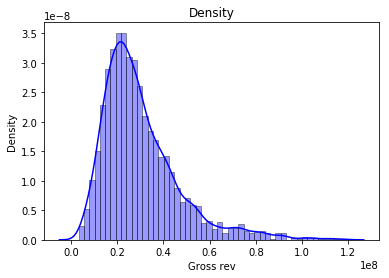

In [63]:
sns.distplot(dff['Gross revenue'], hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})
plt.title('Density')
plt.xlabel('Gross rev')
plt.ylabel('Density')
plt.show()

This has a tall steep distribution with a long right tail. This illustrates that the retail stores largely made the same amount of gross revenue with a few stores making much larger gross revenues.

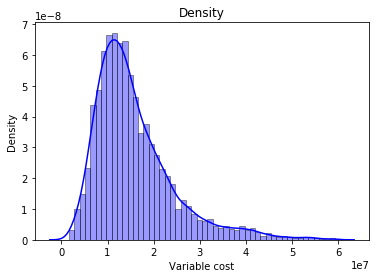

In [64]:
sns.distplot(dff['Variable cost'], hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})

plt.title('Density')
plt.xlabel('Variable cost')
plt.ylabel('Density')
plt.show()

The distribution of variable costs is similar to revenue

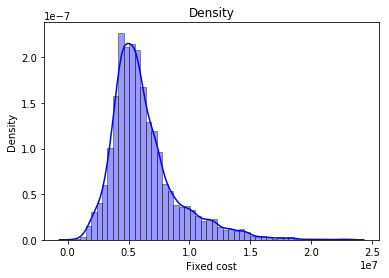

In [65]:
sns.distplot(dff['Fixed cost'], hist=True, kde=True, color = 'blue', hist_kws={'edgecolor':'black'})

plt.title('Density')
plt.xlabel('Fixed cost')
plt.ylabel('Density')
plt.show()

This has an even stronger central tendency than the first two distributions.

Throughout all the above distributions we find a strong central tendency with some right tailed outliers. It is best to proceed using median as our aggregate function over mean.

***Outlier Analysis:***
Look at the extreme outperformers. First, let’s find the profit margins ratios that are multiple standard deviations away from the mean

In [66]:
dff['Z'] = np.abs(stats.zscore(dff['NetProfitMarginRatio']._get_numeric_data()))
z_test=dff[dff.Z>3]
z_test.sort_values('NetProfitMargin')

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio,Qtr,Bin,Z
780,66,1,CA,"11,750,789.77","8,342,790.85","11,042,628.75","33,530.00",4311,False,"708,161.02","-7,668,159.83",0.06,-0.65,Qtr1,Bin 4333,10.69
783,66,4,CA,"18,165,874.10","9,394,500.16","15,661,144.91","33,530.00",4311,False,"2,504,729.19","-6,923,300.97",0.14,-0.38,Qtr2,Bin 4333,7.45
3747,313,4,CA,"18,595,187.39","11,370,238.48","13,554,315.53","186,600.00",4074,False,"5,040,871.86","-6,515,966.62",0.27,-0.35,Qtr2,Bin 4333,7.08
1325,111,6,GA,"10,215,195.60","5,498,775.61","6,904,761.79","86,680.00",4300,False,"3,310,433.81","-2,275,021.80",0.32,-0.22,Qtr2,Bin 4333,5.56
3616,302,5,TX,"10,031,507.93","4,296,117.11","7,939,311.00","37,370.00",4247,False,"2,092,196.93","-2,241,290.18",0.21,-0.22,Qtr2,Bin 4333,5.57
3353,280,6,CA,"12,815,600.02","4,361,828.75","10,351,074.29","153,860.00",4333,False,"2,464,525.73","-2,051,163.02",0.19,-0.16,Qtr2,Bin 4333,4.81
1752,147,1,CA,"10,464,236.25","4,560,721.71","7,426,045.24","149,530.00",4338,False,"3,038,191.01","-1,672,060.70",0.29,-0.16,Qtr1,Bin 4333,4.81
3352,280,5,CA,"9,844,018.07","4,421,619.86","6,806,997.96","153,860.00",4333,False,"3,037,020.11","-1,538,459.75",0.31,-0.16,Qtr2,Bin 4333,4.76
1881,157,10,WA,"4,821,980.61","2,134,286.86","4,018,789.56","83,130.00",3810,False,"803,191.05","-1,414,225.81",0.17,-0.29,Qtr4,Bin 4333,6.40
1883,157,12,WA,"6,452,079.71","3,175,142.10","4,567,781.66","83,130.00",3810,False,"1,884,298.05","-1,373,974.05",0.29,-0.21,Qtr4,Bin 4333,5.44


We now have the lowest and highest profit margins in one data set. Look at which variables differ the most between the height and low profit margins ratio.

In [67]:
z_test.groupby('State').median().sort_values('NetProfitMarginRatio')

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio,Z
State,,,,,,,,,,,,,
CA,280.00,5.00,"12,815,600.02","8,342,790.85","11,042,628.75","153,860.00","4,319.00",False,"3,038,191.01","-1,538,459.75",0.31,-0.16,4.76
WA,157.00,7.00,"7,394,514.02","3,504,380.81","4,667,985.00","83,130.00","3,810.00",False,"2,726,529.02","-451,988.86",0.43,-0.10,4.29
IL,94.00,4.00,"8,334,944.59","4,270,162.18","4,709,103.66","82,390.00","4,329.00",False,"3,625,840.93","-750,721.78",0.35,-0.09,4.00
TX,302.00,5.00,"6,668,423.22","3,505,937.84","3,804,071.41","57,680.00","4,247.00",False,"2,860,677.49","-637,021.76",0.44,-0.06,3.60
CO,74.00,12.00,"12,969,614.96","5,719,440.99","7,697,201.86","220,940.00","4,344.00",False,"5,272,413.10","-667,967.89",0.41,-0.05,3.51
GA,78.00,4.00,"5,932,841.58","2,757,206.16","3,335,932.16","79,370.00","4,294.50",False,"2,596,909.42","-215,001.74",0.43,-0.04,3.34
NJ,126.00,7.00,"12,416,165.13","5,196,631.02","7,337,302.54","122,500.00","4,231.00",False,"5,078,862.58","-232,948.13",0.41,-0.02,3.19


In [68]:
z_test.groupby('Qtr').median().sort_values('NetProfitMarginRatio')

,Location number,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio,Z
Qtr,,,,,,,,,,,,,
Qtr4,157.00,11.50,"7,493,155.93","3,856,635.85","4,806,597.21","83,280.00","4,244.00",False,"2,686,558.72","-1,124,610.61",0.37,-0.14,4.56
Qtr2,254.00,5.00,"9,777,817.08","4,328,972.93","6,295,721.58","84,905.00","4,273.50",False,"3,173,726.96","-838,501.12",0.32,-0.12,4.38
Qtr1,255.50,1.50,"8,877,661.07","4,018,037.17","5,263,831.04","83,130.00","4,268.00",False,"2,801,815.33","-424,647.99",0.42,-0.03,3.28
Qtr3,198.00,8.00,"29,543,244.07","4,883,629.12","7,538,673.30","176,832.25","4,637.00",False,"22,988,001.56","18,267,831.10",0.65,0.50,3.33


In [69]:
z_test.groupby('Month').median().sort_values('NetProfitMarginRatio')

,Location number,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio,Z
Month,,,,,,,,,,,,
10,157.00,"4,821,980.61","2,134,286.86","4,018,789.56","83,130.00","3,810.00",False,"803,191.05","-1,414,225.81",0.17,-0.29,6.40
11,157.00,"5,400,826.70","2,739,861.51","3,694,316.19","83,130.00","4,180.00",False,"1,769,594.14","-1,116,481.00",0.34,-0.15,4.64
6,291.00,"11,515,397.81","4,544,003.47","8,627,918.04","76,940.00","4,273.50",False,"3,085,555.65","-1,459,397.64",0.29,-0.13,4.45
4,192.50,"9,621,763.61","4,403,647.23","5,558,193.91","103,170.00","4,271.00",False,"3,776,505.91","-788,450.62",0.36,-0.12,4.34
1,157.00,"6,208,699.81","3,358,818.60","3,702,089.22","72,060.00","4,298.00",False,"2,506,610.59","-451,988.86",0.43,-0.10,4.13
5,203.00,"8,995,663.14","3,997,966.85","5,677,799.75","76,760.00","4,290.00",False,"2,862,114.17","-897,235.97",0.38,-0.10,4.10
12,115.50,"10,751,923.55","5,128,785.29","6,371,307.31","137,030.00","4,326.00",False,"4,380,616.24","-900,354.06",0.41,-0.09,4.00
2,292.50,"14,045,642.05","5,835,402.13","8,417,569.14","89,715.00","4,272.50",False,"5,628,072.91","-538,131.58",0.39,-0.03,3.27
3,288.00,"7,394,514.02","3,504,380.81","4,667,985.00","128,850.00","4,206.00",False,"2,726,529.02","-166,343.08",0.42,-0.01,3.06


In [70]:
z_test.groupby('Location number').median().sort_values('NetProfitMarginRatio')

,Month,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,GrossProfitMargin,NetProfitMargin,GrossProfitMarginRatio,NetProfitMarginRatio,Z
Location number,,,,,,,,,,,,
66,2.50,"14,958,331.94","8,868,645.50","13,351,886.83","33,530.00","4,311.00",False,"1,606,445.11","-7,295,730.40",0.10,-0.52,9.07
111,6.00,"10,215,195.60","5,498,775.61","6,904,761.79","86,680.00","4,300.00",False,"3,310,433.81","-2,275,021.80",0.32,-0.22,5.56
157,7.00,"5,407,343.33","2,603,381.84","3,856,552.88","83,130.00","3,810.00",False,"1,812,480.11","-988,731.40",0.32,-0.18,5.03
147,1.00,"10,464,236.25","4,560,721.71","7,426,045.24","149,530.00","4,338.00",False,"3,038,191.01","-1,672,060.70",0.29,-0.16,4.81
280,5.50,"11,329,809.05","4,391,724.30","8,579,036.12","153,860.00","4,333.00",False,"2,750,772.92","-1,794,811.38",0.25,-0.16,4.79
298,11.00,"5,137,725.93","2,437,925.92","3,368,131.79","82,390.00","4,180.00",False,"1,769,594.14","-750,721.78",0.34,-0.15,4.64
286,12.00,"8,534,232.14","4,538,129.60","5,045,412.76","83,430.00","4,350.00",False,"3,488,819.38","-1,132,740.22",0.41,-0.13,4.48
230,7.00,"3,307,785.29","2,034,026.71","1,644,293.78","61,800.00","4,319.00",False,"1,663,491.51","-432,335.20",0.50,-0.13,4.46
228,2.50,"7,449,432.11","3,947,975.44","4,206,546.36","57,680.00","4,531.00",False,"3,242,885.75","-762,769.69",0.43,-0.13,4.40


Simplify the data to make our analysis easier to observe.

In [71]:
low_pm=z_test[z_test.NetProfitMarginRatio<.0]
high_pm=z_test[z_test.NetProfitMarginRatio>.4]

In [72]:
print('The median gross revenue for locations with high profit margin is: {:,}'.format(high_pm['Gross revenue'].median()))
print('The median gross revenue for locations with low profit margin is: {:,}'.format(low_pm['Gross revenue'].median()))
print('The difference in gross revenue between high and low profit margin locations is: {:,}'.format(high_pm['Gross revenue'].median()-low_pm['Gross revenue'].median()))

The median gross revenue for locations with high profit margin is: 37,341,919.15
The median gross revenue for locations with low profit margin is: 9,621,763.6115
The difference in gross revenue between high and low profit margin locations is: 27,720,155.538499996


In [73]:
print('The median number of products for locations with high profit margin is: {:,}'.format(high_pm['Number of products'].median()))
print('The median number of products for locations with low profit margin is: {:,}'.format(low_pm['Number of products'].median()))
print('The difference in number of products between high and low profit margin locations is: {:,}'.format(high_pm['Number of products'].median()-low_pm['Number of products'].median()))

The median number of products for locations with high profit margin is: 4,694.0
The median number of products for locations with low profit margin is: 4,247.0
The difference in number of products between high and low profit margin locations is: 447.0


In [74]:
print('The median fixed cost for locations with high profit margin is: {:,}'.format(high_pm['Fixed cost'].median()))
print('The median fixed cost for locations with low profit margin is: {:,}'.format(low_pm['Fixed cost'].median()))
print('The difference in fixed cost between high and low profit margin locations is: {:,}'.format(high_pm['Fixed cost'].median()-low_pm['Fixed cost'].median()))

The median fixed cost for locations with high profit margin is: 5,232,967.58
The median fixed cost for locations with low profit margin is: 4,328,972.93
The difference in fixed cost between high and low profit margin locations is: 903,994.6500000004


In [75]:
print('The median variable cost for locations with high profit margin is: {:,}'.format(high_pm['Variable cost'].median()))
print('The median variable cost for locations with low profit margin is: {:,}'.format(low_pm['Variable cost'].median()))
print('The difference in variable cost between high and low profit margin locations is: {:,}'.format(high_pm['Variable cost'].median()-low_pm['Variable cost'].median()))

The median variable cost for locations with high profit margin is: 11,857,593.62
The median variable cost for locations with low profit margin is: 5,558,193.905
The difference in variable cost between high and low profit margin locations is: 6,299,399.714999999


In [76]:
print('The median rental cost for locations with high profit margin is: {:,}'.format(high_pm['Rental cost'].median()))
print('The median rental cost for locations with low profit margin is: {:,}'.format(low_pm['Rental cost'].median()))
print('The difference in rental cost between high and low profit margin locations is: {:,}'.format(high_pm['Rental cost'].median()-low_pm['Rental cost'].median()))

The median rental cost for locations with high profit margin is: 180,920.0
The median rental cost for locations with low profit margin is: 83,130.0
The difference in rental cost between high and low profit margin locations is: 97,790.0


***Findings from outlier analysis:*** Again, the analysis confirms our earlier findings that the number of products a location has the better their profit margin performance.

***Predictive model analysis***
Analyze the predictive ability the number of products in a location has on profit margin.

###### Split data
First, we need to split the data into a training set and a testing set. The goal is to not over fit your model. If you test your data with the same data, you trained your model with then you are likely to get an overfitted model. By splitting the data, you can test your model without using any of the data points you used to test the model. I tend to like to train using 70%-80% of my data and testing with the remaining 20%-30%. 

In [ ]:
df.Owned.value_counts(normalize=True)

In [133]:
#x = dff['Number of products'].values
#y = dff['NetProfitMargin'].values
x = dff.loc[:, dff.columns == 'Number of products'].values
y = dff.loc[:, dff.columns == 'NetProfitMarginRatio'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state=25)

In [134]:
regr= linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

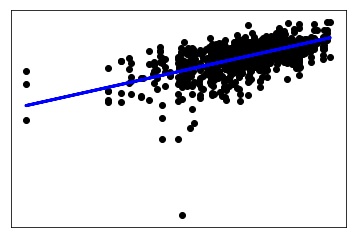

In [135]:
plt.scatter(x_test,y_test, color='black')
plt.plot(x_test, regr.predict(x_test), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

# Conclusion
Number of products is the largest indicator of profit margin performance. Geographical location also has a significant effect.